# Vertex Model Grid (DISV) plotting 

No problem! Flopy supports vertex model grid plotting through the `PlotMapView` and `PlotCrossSection` classes. 

The method calls are almost identical to models that use a Structured Model Grid (DIS) to define the model discretization and the same keyword arguments are supported. Let's run through an example using a vertex model grid.

First let's import flopy and get the model loaded!

In [1]:
%matplotlib inline
import flopy as fp
from flopy.plot import PlotMapView, PlotCrossSection
from flopy.utils import HeadFile, CellBudgetFile, geometry
import matplotlib.pyplot as plt
import numpy as np
import os

# load up the example problem
sim_name = "mfsim.nam"
sim_path = "../data/mf6/test003_gwftri_disv"
sim = fp.mf6.MFSimulation.load(sim_name=sim_name, version="mf6", exe_name="mf6",
                               sim_ws=sim_path)

Directory structure already exists for simulation path C:\Users\jlarsen\Desktop\flopy-ogw\trunk\examples\Notebooks\..\data\mf6\test003_gwftri_disv
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package chd...
    loading package oc...
  loading ims package gwf_1...


Now let's check the model name and then get an instance of our model

In [2]:
sim.model_names

['gwf_1']

In [3]:
ml = sim.get_model('gwf_1')
ml

name = gwf_1
model_type = gwf
version = mf6
model_relative_path = 

###################
Package disv
###################

package_name = disv
filename = tri_model_cnst.disv
package_type = disv
model_or_simulation_package = model
model_name = gwf_1


###################
Package ic
###################

package_name = ic
filename = tri_model.ic
package_type = ic
model_or_simulation_package = model
model_name = gwf_1


###################
Package npf
###################

package_name = npf
filename = tri_model.npf
package_type = npf
model_or_simulation_package = model
model_name = gwf_1


###################
Package chd_left
###################

package_name = chd_left
filename = tri_model_left.chd
package_type = chd
model_or_simulation_package = model
model_name = gwf_1


###################
Package chd_right
###################

package_name = chd_right
filename = tri_model_right.chd
package_type = chd
model_or_simulation_package = model
model_name = gwf_1


###################
Package o

## Build a vertex model grid object
The `VertexModelGrid` in not yet integrated into FloPy, but will be shortly. Until then we can build a `VertexModelGrid` instance to use for plotting

In [4]:
from flopy.discretization import VertexGrid

vmg = VertexGrid(ml.dis.vertices.array, ml.dis.cell2d.array,
                 top=ml.dis.top.array, botm=ml.dis.botm.array,
                 idomain=ml.dis.idomain.array, angrot=-25)
vmg

xll:0; yll:0; rotation:-25; proj4_str:None; units:; lenuni:None; length_multiplier:1

Now all the discretization information is available to be used to plot model data in a `PlotMapView` or `PlotCrossSection` object

Let's begin with `PlotMapView` and plot the model grid.

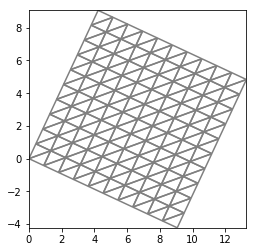

In [5]:
vmap = PlotMapView(modelgrid=vmg, layer=0)
ax = vmap.plot_grid()

As we can see, the model grid plots as a series of grid lines.

We can also plot inactive cells using `plot_inactive`

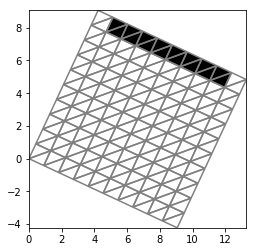

In [6]:
vmap = PlotMapView(modelgrid=vmg, layer=0)
ax = vmap.plot_inactive()
vmap.plot_grid()

Model data can be plotted using the `plot_array` method as follows:

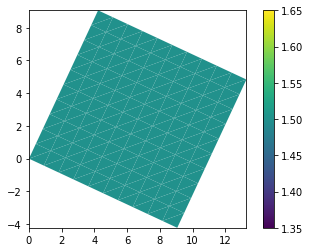

In [7]:
vmap = PlotMapView(modelgrid=vmg, layer=0)
ax = vmap.plot_array(a=ml.dis.botm.array)
plt.colorbar(ax)

This plot shows the bottom elevations of layer 1. These are a constant value of 1.5 in this example.

Let's import some data from the model output to use with `plot_array()` to illustrate plotting better.

In [8]:
hds_file = os.path.join(sim_path, "tri_model.hds")
cbc_file = os.path.join(sim_path, "tri_model.cbc")

hds = HeadFile(hds_file)
hdata = hds.get_alldata()[0]
hdata.shape = (4, -1)

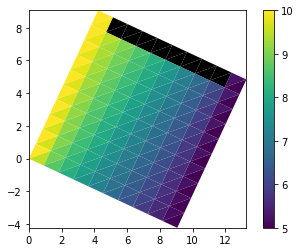

In [9]:
vmap = PlotMapView(modelgrid=vmg, layer=0)
ax = vmap.plot_inactive()
ax = vmap.plot_array(a=hdata.ravel(), masked_values=[1e30])
plt.colorbar(ax)

Data can also be contoured using the `contour_array` method.

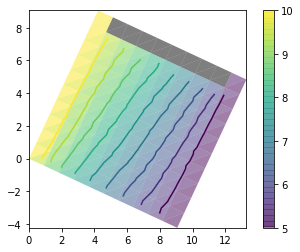

In [10]:
vmap = PlotMapView(modelgrid=vmg, layer=0)
ax = vmap.plot_inactive(alpha=0.5)
ax = vmap.plot_array(a=hdata[0], masked_values=[1e30], alpha=0.5)
levels = np.arange(5, 10, 0.5)
vmap.contour_array(a=hdata[0], masked_values=[1e30], levels=levels)
plt.colorbar(ax)

### Plotting specific discharge

This method is slightly different than the structured grid methodology.

1st we need to get the flow ja face output from the binary cell by cell output file

In [11]:
cbc = CellBudgetFile(cbc_file, precision='double')
fja = cbc.get_data(text="FLOW-JA-FACE")
fja

[array([[[ 0.        , -0.13452464, -0.2301623 , ...,  0.        ,
          -0.060783  ,  0.060783  ]]])]

Now we can pass the flow ja face array to `plot_discharge`; FloPy will automatically make the flow connections and vectorize the flow for us.

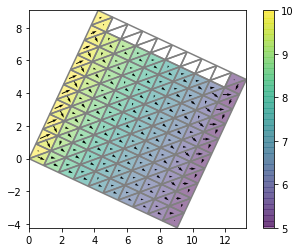

In [12]:
vmap = PlotMapView(modelgrid=vmg, layer=0)
ax = vmap.plot_grid()
ax = vmap.plot_array(a=hdata, alpha=0.5, masked_values=[1e30])
plt.colorbar(ax)
ax = vmap.plot_discharge(fja=fja, head=hdata)


# Working with model cross sections

Flopy supports cross sections for vertex model grids, similarly to structured model grids by using the `PlotCrossSection` class. In fact most of the functionality is identical to `PlotCrossSection` with a Structured model grid. 

### Note:
Cross sections must be defined by a line, since there is no row or column in a vertex model grid.

Let's start by creating our cross section line and showing it on a `PlotMapView` object. 

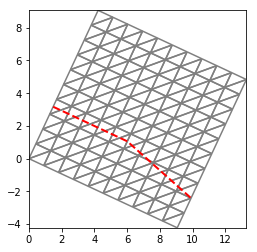

In [13]:
# define a line through the model in model coordiantes as a 
# series of XY vertices where the cross section will be sliced!
line = np.array([(0,3.5), (5, 3.5), (10, 2)])

# Transform the line into the spatial refenernce projection to match the projected coordiates
# Question? should we give the user a model grid based vertex option?
line = geometry.transform(line.T[0], line.T[1], 
                           vmg.xoffset, vmg.yoffset, 
                           vmg.angrot_radians)

vmap = PlotMapView(modelgrid=vmg, layer=0)
ax = vmap.plot_grid()
plt.plot(line[0], line[1], 'r--', linewidth=2)

Now that we see our cross section line traverses the simulation domain where we were expecting it, let's create a cross section using the `PlotCrossSection` and plot the model grid using `plot_grid`

Our cross section line is passed to the `line` dictionary

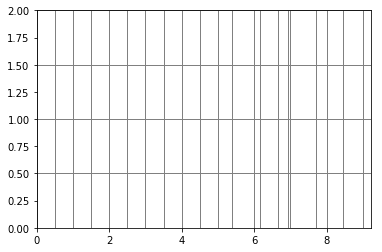

In [14]:
line = np.array(line).T

vcs = PlotCrossSection(modelgrid=vmg, line={"line": line})
vcs.plot_grid()

Array data can be plotted over similarly to the `PlotMapView` example by calling the `plot_array` method.

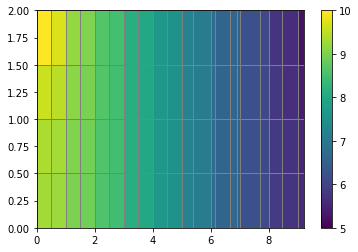

In [15]:
vcs = PlotCrossSection(modelgrid=vmg, line={"line": line})

ax = vcs.plot_array(a=hdata, masked_values=[1e30])
plt.colorbar(ax)
vcs.plot_grid()

Contour plots can also be made using the `contour_array()` method. 

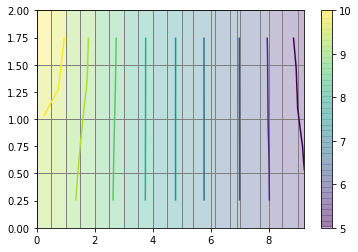

In [16]:
vcs = PlotCrossSection(modelgrid=vmg, line={"line": line})

ax = vcs.plot_array(a=hdata, masked_values=[1e30], alpha=0.3)
plt.colorbar(ax)
# set our own contour levels using the matplotlib keyword argument levels
levels = np.arange(5, 10, 0.5)
vcs.contour_array(a=hdata, masked_values=[1e30], levels=levels)
vcs.plot_grid()

## Plotting discharge

Discharge is plotted similarly to the previous example:

The FLOW JA FACE array is used with `plot_discharge` to create and plot flow vectors

### Note:
Arbitrary cross section lines cannot be used with this method. A straight cross section must be supplied to calculate discharge vectors.

(0, 10)

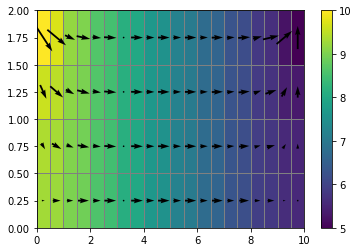

In [17]:
# Added 0.01 to 10 to account for precision issues with transforms...
line = np.array([(-0.1, 3.5), (10.1, 3.5)])

# Transform the line into the spatial refenernce projection to match the projected coordiates
line = geometry.transform(line.T[0], line.T[1], 
                           vmg.xoffset, vmg.yoffset, 
                           vmg.angrot_radians)
line = np.array(line).T

vcs = PlotCrossSection(modelgrid=vmg, line={"line": line})
ax = vcs.plot_array(a=hdata, masked_values=[1e30])
plt.colorbar(ax)
vcs.plot_grid()
ax = vcs.plot_discharge(fja=fja, head=hdata)
plt.xlim([0, 10])

The discharge vectors look a little different due to the triangular nature of the grid 

### Let's load up a square grid example and plot up discharge vectors.

In [18]:
sim_name = "mfsim.nam"
sim_path = "../data/mf6/test003_gwfs_disv"
sim = fp.mf6.MFSimulation.load(sim_name=sim_name, version="mf6", exe_name="mf6",
                               sim_ws=sim_path)

ml = sim.get_model('gwf_1')
vmg = VertexGrid(ml.dis.vertices.array, ml.dis.cell2d.array,
                 top=ml.dis.top.array, botm=ml.dis.botm.array,
                 idomain=ml.dis.idomain.array, xoff=10,
                 yoff=0, angrot=-25)

cbc_file = os.path.join(sim_path, "expected_output/", "model_unch.cbc")
hds_file = os.path.join(sim_path, "expected_output/", "model_unch.hds")

cbc = CellBudgetFile(cbc_file, precision='double')
fja = cbc.get_data(text="FLOW JA FACE")

hds = HeadFile(hds_file)
hdata = hds.get_alldata()[0]
hdata.shape = (4, -1)

Directory structure already exists for simulation path C:\Users\jlarsen\Desktop\flopy-ogw\trunk\examples\Notebooks\..\data\mf6\test003_gwfs_disv
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package chd...
    loading package oc...
  loading ims package gwf_1...


Now let's plot the discharge vectors for a model with a grid of uniform elevations

(0, 10)

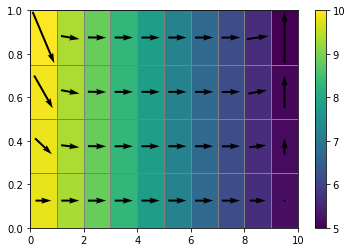

In [19]:
# Added 0.01 to 10 to account for precision issues with transforms...
line = np.array([(-0.1, 2.5), (10.1, 2.5)])

# Transform the line into the spatial refenernce projection to match the projected coordiates
line = geometry.transform(line.T[0], line.T[1], 
                          vmg.xoffset, vmg.yoffset, 
                          vmg.angrot_radians)
line = np.array(line).T

vcs = PlotCrossSection(modelgrid=vmg, line={"line": line})
ax = vcs.plot_array(a=hdata, masked_values=[1e30])
plt.colorbar(ax)
vcs.plot_grid()
ax = vcs.plot_discharge(fja=fja, head=hdata)
plt.xlim([0, 10])

These discharge vectors are much more uniform as expected.

### For more information about the plotting functionality in flopy including optional keyword arguments, please see the ipython notebook: flopy3_PlotArrayExample.ipynb

### Happy plotting!